## CC_fraud
### Detection of fraudulent credit card transactions
Using the Kaggle [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset

### About the data

1. Contains transactions made by credit cards in Sept 2013 by European card holders
2. Imbalanced data (473 (~ 0.2%) fraudulent cases)
3. Features have been PCA transformed for confidentiality issues
4. Time and amount are the non-transformed features

### Goals

1. Identify fraudulent cases
2. Accuracy doesn't mean anything with this kind of imbalance, choose suitable metric

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
%matplotlib inline

### Inspecting the data 

In [2]:
#import and read supplied file
cc_data = pd.read_csv('../data/creditcard.csv')
cc_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# List of columns for use later
cc_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

#### Checking for any missing values

In [5]:
# Let's first take a look at the column structure and check for any missing data
print("Table size -", end=' ')
print(cc_data.shape)

print("Checking for missing values..")
# Number of missing values in each column of training data
missing_val_count_by_column = (cc_data.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

# Get names of columns with missing values
missing_cols = [col for col in cc_data.columns
                     if cc_data[col].isnull().any()]

Table size - (284807, 31)
Checking for missing values..
Series([], dtype: int64)


284807 rows with no missing data

#### Check for duplicates

In [6]:
# Duplicates do exist
cc_data[cc_data.duplicated(keep=False)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
112,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,...,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284190,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0
284192,172233.0,-2.691642,3.123168,-3.339407,1.017018,-0.293095,-0.167054,-0.745886,2.325616,-1.634651,...,0.402639,0.259746,-0.086606,-0.097597,0.083693,-0.453584,-1.205466,-0.213020,36.74,0


In [7]:
# 1081 duplicate rows
cc_data[cc_data.duplicated()]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282987,171288.0,1.912550,-0.455240,-1.750654,0.454324,2.089130,4.160019,-0.881302,1.081750,1.022928,...,-0.524067,-1.337510,0.473943,0.616683,-0.283548,-1.084843,0.073133,-0.036020,11.99,0
283483,171627.0,-1.464380,1.368119,0.815992,-0.601282,-0.689115,-0.487154,-0.303778,0.884953,0.054065,...,0.287217,0.947825,-0.218773,0.082926,0.044127,0.639270,0.213565,0.119251,6.82,0
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,...,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0


In [8]:
# Drop duplicates except the first
cc_data.drop_duplicates(inplace=True)

In [9]:
len(cc_data)

283726

In [14]:
# Data mostly continuous. Check value counts of class
# Our drop duplicates didn't drop any of the fraudulent data
cc_data['Class'].value_counts()

0    283253
1       473
Name: Class, dtype: int64

In [26]:
# Class imbalance
c=(len(cc_data[cc_data['Class']==1])/len(cc_data)*100)
print(f'Only {c:.2f}% of the data are fraud')

Only 0.17% of the data are fraud


#### Variable distributions

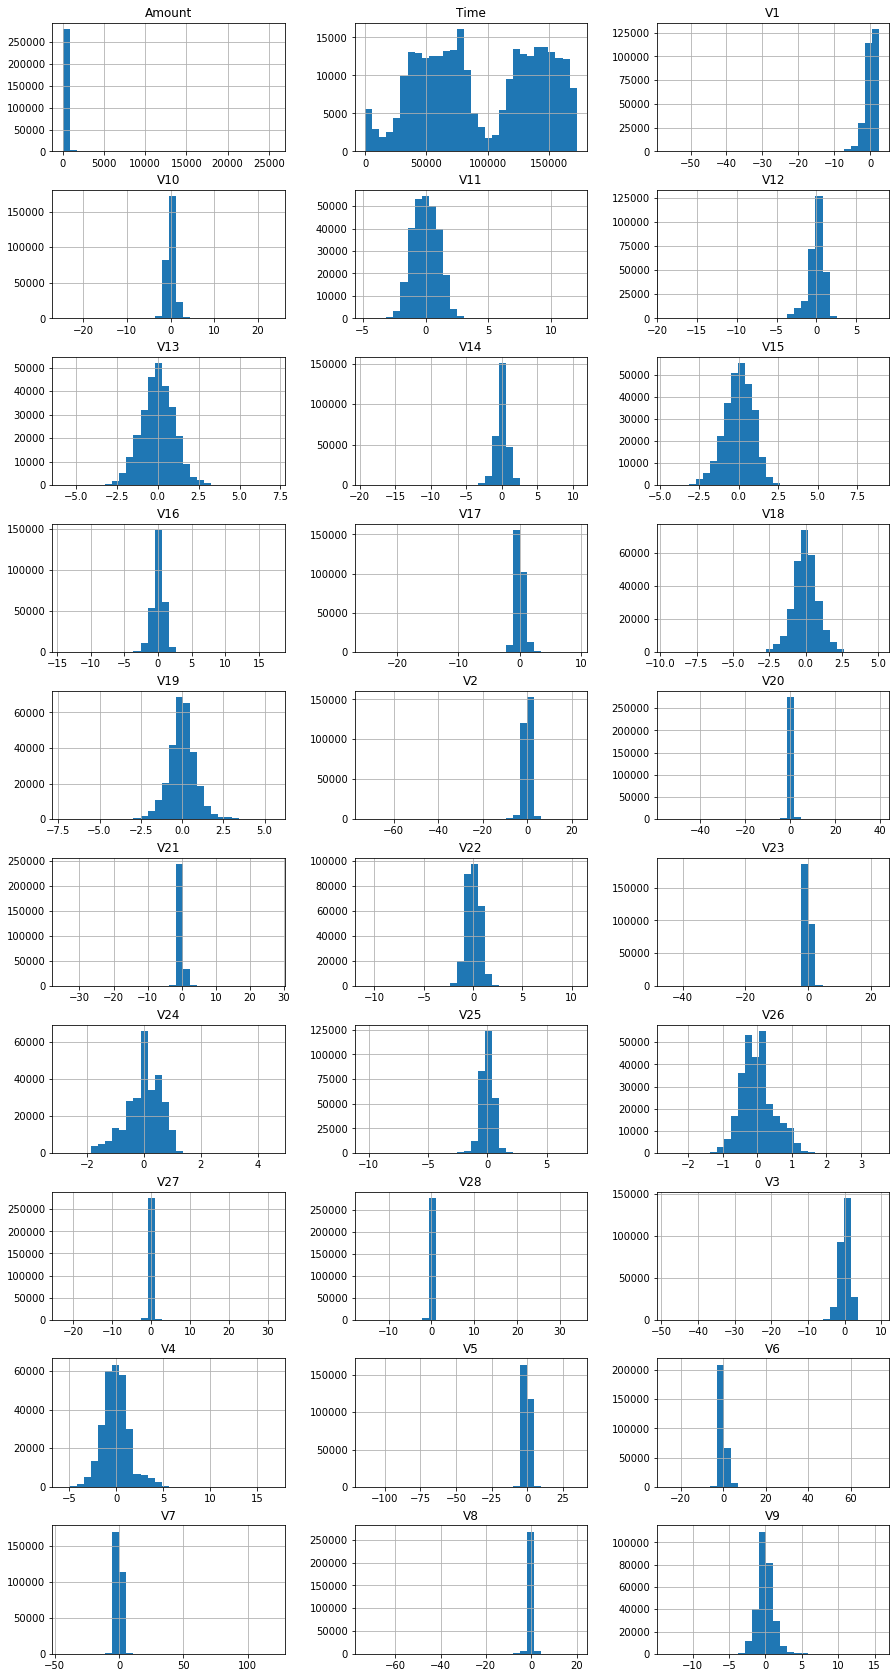

In [32]:
# Histograms of variables
# Could log transform Amount and some kind of odd number root (because negative values) of the other variables which have sharp peaks
# Variables that are good the way they are - Time, V11, V13, V15, V18, V19, V22, V24, V26, V4, V9
cc_data.drop(['Class'], axis=1).hist(bins=30, figsize=(15, 30), layout=(10, 3));

In [34]:
cc_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


### Look at time specifically 
1. Either 2 days worth of data or a different time scale
2. In any case shouldn't add anything to the model
3. Could think of time of day effects (maybe fraud transactions happen at odd hours) but no info for that here

In [43]:
# The max time divided by seconds/minutes/hours = 2
max(cc_data['Time'])/60/60/24

1.9999074074074075

### Other columns
1. Nothing too weird about amount. Just need to log transform it + 1 because the minimum is 0.
2. Other columns are all PCA transformed variables with mean 0.
3. Since they are from PCA I would expect not much correlation but let's check

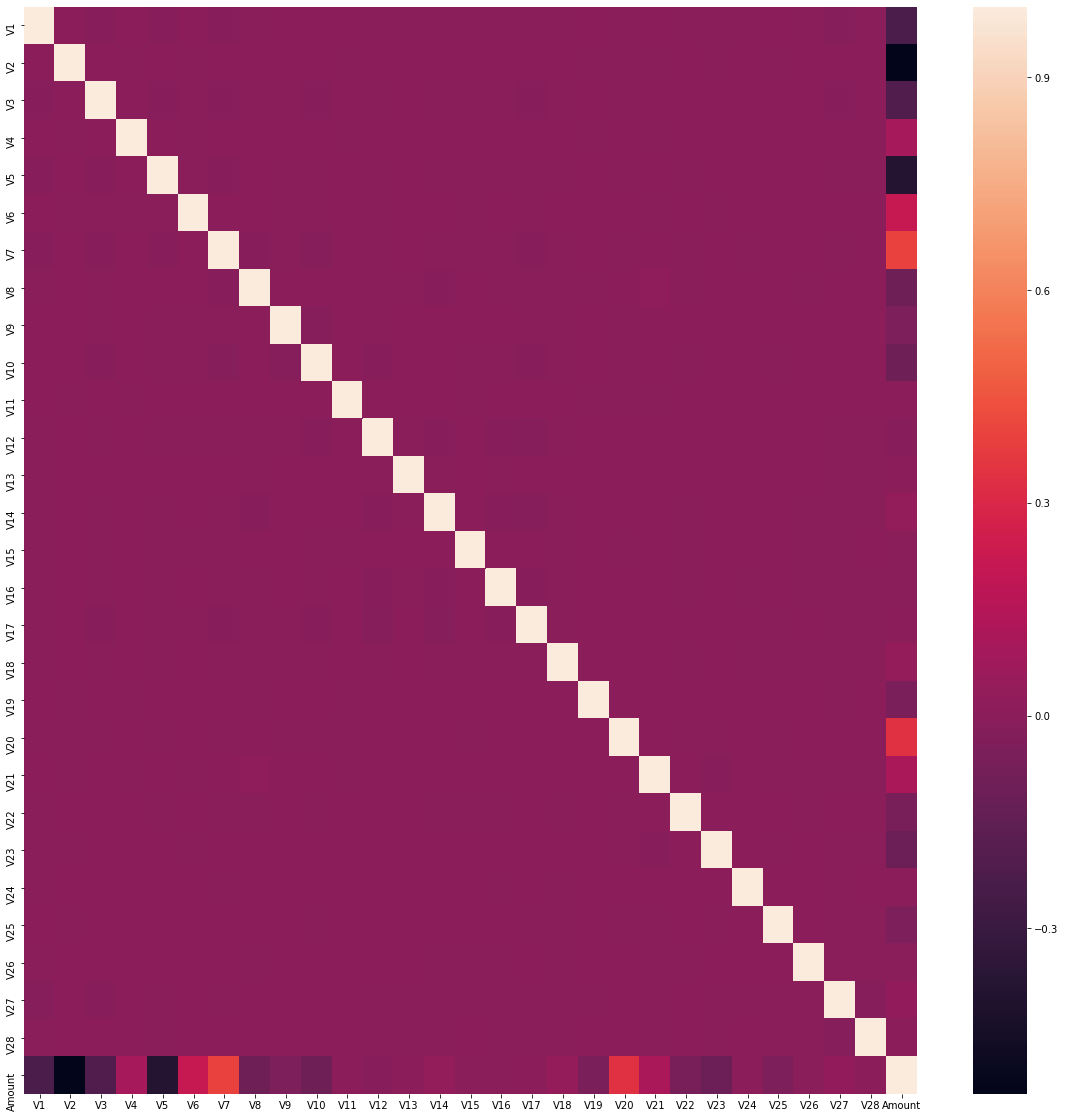

In [50]:
# calculate correlation matrix. Very low correlation between variables as expected
plt.figure(figsize=(20,20))
corr = cc_data.drop(['Time','Class'], axis=1).corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=False)

### Variable transformations

In [10]:
cols_to_retain = ['V11', 'V13', 'V15', 'V18', 'V19', 'V22', 'V24', 'V26', 'V4', 'V9']
cc_data_tf = cc_data[cols_to_retain] 

In [11]:
cc_data_tf['log_amount+1'] = np.log(cc_data['Amount']+1)

C:\anaconda_python\envs\insight_2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
cols_to_retain.extend(['Time', 'Class', 'Amount'])
cc_data.drop(cols_to_retain, axis=1)

,V1,V2,V3,V5,V6,V7,V8,V10,V12,V14,V16,V17,V20,V21,V23,V25,V27,V28
0,-1.359807,-0.072781,2.536347,-0.338321,0.462388,0.239599,0.098698,0.090794,-0.617801,-0.311169,-0.470401,0.207971,0.251412,-0.018307,-0.110474,0.128539,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.060018,-0.082361,-0.078803,0.085102,-0.166974,1.065235,-0.143772,0.463917,-0.114805,-0.069083,-0.225775,0.101288,0.167170,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,-0.503198,1.800499,0.791461,0.247676,0.207643,0.066084,-0.165946,-2.890083,1.109969,0.524980,0.247998,0.909412,-0.327642,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.010309,1.247203,0.237609,0.377436,-0.054952,0.178228,-0.287924,-1.059647,-0.684093,-0.208038,-0.108300,-0.190321,0.647376,0.062723,0.061458
4,-1.158233,0.877737,1.548718,-0.407193,0.095921,0.592941,-0.270533,0.753074,0.538196,-1.119670,-0.451449,-0.237033,0.408542,-0.009431,-0.137458,-0.206010,0.219422,0.215153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-5.364473,-2.606837,-4.918215,7.305334,4.356170,2.711941,4.626942,1.107641,1.991691,1.475829,0.213454,1.014480,1.436807,0.943651,0.823731
284803,-0.732789,-0.055080,2.035030,0.868229,1.058415,0.024330,0.294869,-0.975926,0.915802,-0.675143,-0.711757,-0.025693,0.059616,0.214205,0.012463,-0.606624,0.068472,-0.053527
284804,1.919565,-0.301254,-3.249640,2.630515,3.031260,-0.296827,0.708417,-0.484782,0.063119,-0.510602,0.140716,0.313502,0.001396,0.232045,-0.037501,0.265745,0.004455,-0.026561
284805,-0.240440,0.530483,0.702510,-0.377961,0.623708,-0.686180,0.679145,-0.399126,-0.962886,0.449624,-0.608577,0.509928,0.127434,0.265245,-0.163298,-0.569159,0.108821,0.104533


In [13]:
np.cbrt(cc_data.drop(cols_to_retain, axis=1)).add_prefix('cbrt_')

,cbrt_V1,cbrt_V2,cbrt_V3,cbrt_V5,cbrt_V6,cbrt_V7,cbrt_V8,cbrt_V10,cbrt_V12,cbrt_V14,cbrt_V16,cbrt_V17,cbrt_V20,cbrt_V21,cbrt_V23,cbrt_V25,cbrt_V27,cbrt_V28
0,-1.107879,-0.417516,1.363755,-0.696802,0.773278,0.621100,0.462135,0.449455,-0.851693,-0.677640,-0.777719,0.592472,0.631144,-0.263555,-0.479829,0.504675,0.511160,-0.276125
1,1.060249,0.643244,0.550116,0.391525,-0.435084,-0.428727,0.439858,-0.550660,1.021289,-0.523872,0.774129,-0.486019,-0.410321,-0.608918,0.466143,0.550875,-0.207878,0.245100
2,-1.107485,-1.102518,1.210375,-0.795389,1.216553,0.925003,0.628002,0.592160,0.404295,-0.549527,-1.424416,1.035389,0.806704,0.628275,0.968843,-0.689392,-0.381107,-0.390946
3,-0.988628,-0.570034,1.214860,-0.217639,1.076413,0.619376,0.722683,-0.380184,0.562763,-0.660327,-1.019500,-0.881127,-0.592535,-0.476662,-0.575213,0.865072,0.397321,0.394632
4,-1.050184,0.957462,1.156975,-0.741197,0.457761,0.840112,-0.646755,0.909800,0.813417,-1.038397,-0.767131,-0.618875,0.742014,-0.211275,-0.516088,-0.590603,0.603152,0.599215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-2.281843,2.159578,-2.142504,-1.750555,-1.376273,-1.700601,1.940350,1.633183,1.394526,1.666344,1.034665,1.258174,1.138532,0.597633,1.004804,1.128408,0.980853,0.937408
284803,-0.901556,-0.380481,1.267234,0.953992,1.019104,0.289765,0.665594,-0.991910,0.971107,-0.877267,-0.892848,-0.295078,0.390650,0.598334,0.231850,-0.846525,0.409109,-0.376870
284804,1.242799,-0.670364,-1.481193,1.380427,1.447242,-0.667064,0.891449,-0.785565,0.398156,-0.799271,0.520133,0.679329,0.111761,0.614503,-0.334719,0.642918,0.164541,-0.298365
284805,-0.621826,0.809513,0.888964,-0.723018,0.854398,-0.882022,0.878997,-0.736269,-0.987472,0.766096,-0.847433,0.798920,0.503224,0.642514,-0.546588,-0.828726,0.477424,0.471069


In [16]:
cc_data_tf = pd.concat([cc_data_tf, np.cbrt(cc_data.drop(cols_to_retain, axis=1)).add_prefix('cbrt_'), cc_data['Class']], axis=1)

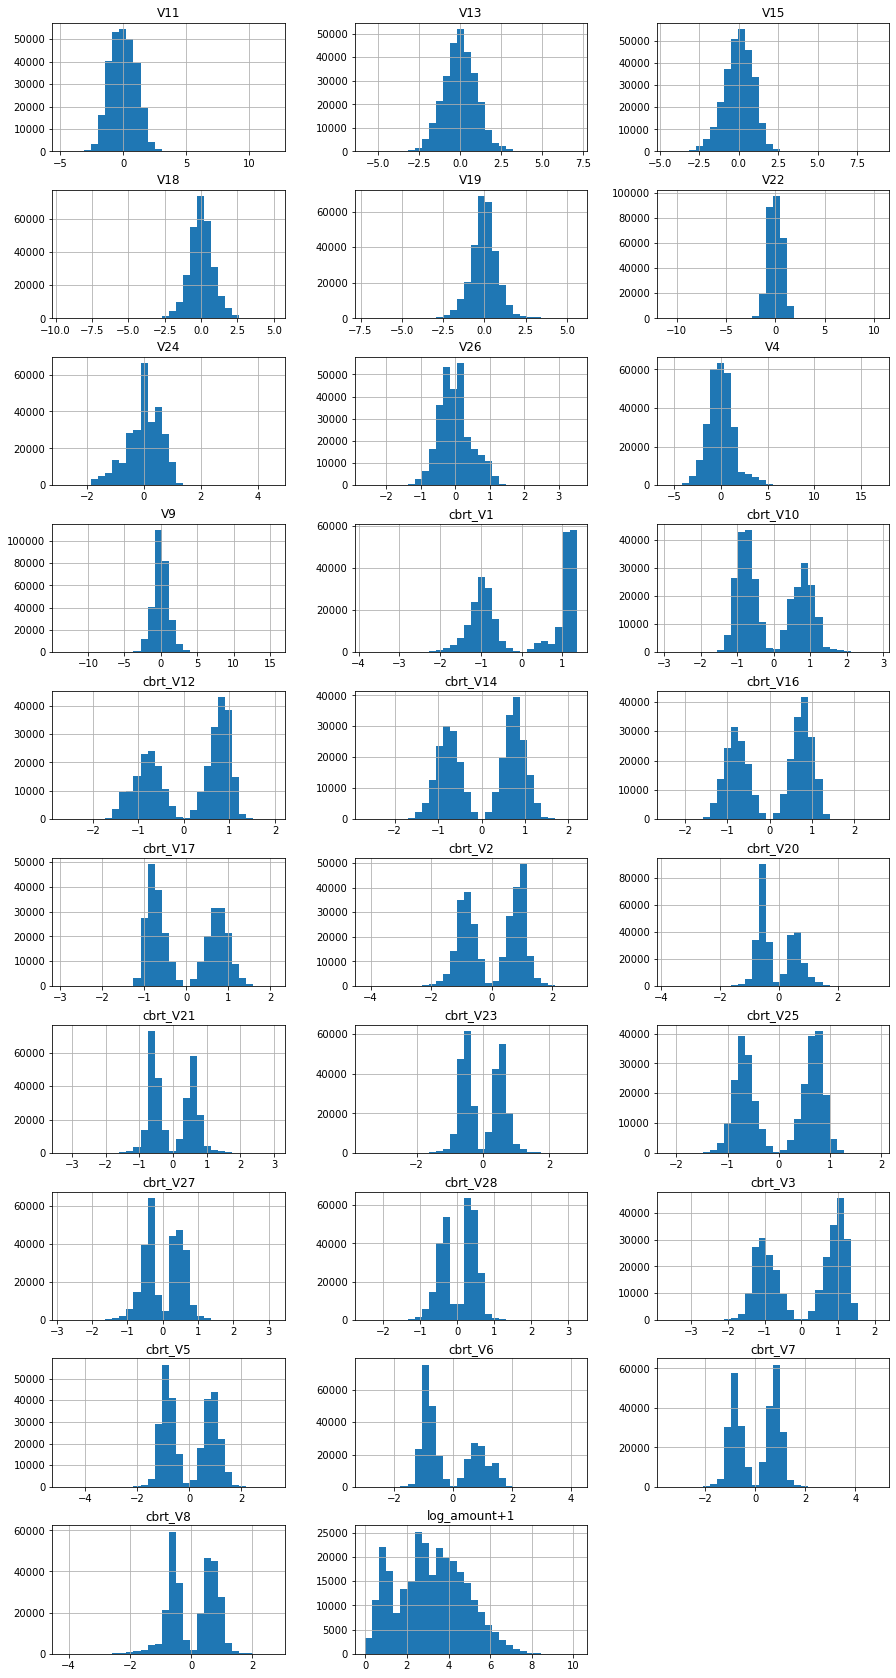

In [22]:
# Histograms of variables
# Quite a few bimodal variables now, but better than before
cc_data_tf.drop(['Class'], axis=1).hist(bins=30, figsize=(15, 30), layout=(10, 3));

In [20]:
# Save as transformed dataset
export = cc_data_tf.to_csv('../data/cc_data_tf.csv', header=True, index = True)

## Modeling

In [5]:
#import and read transformed file
cc_data_tf = pd.read_csv('../data/cc_data_tf.csv', index_col=0)
cc_data_tf.head()

,V11,V13,V15,V18,V19,V22,V24,V26,V4,V9,...,cbrt_V14,cbrt_V16,cbrt_V17,cbrt_V20,cbrt_V21,cbrt_V23,cbrt_V25,cbrt_V27,cbrt_V28,Class
0,-0.551600,-0.991390,1.468177,0.025791,0.403993,0.277838,0.066928,-0.189115,1.378155,0.363787,...,-0.677640,-0.777719,0.592472,0.631144,-0.263555,-0.479829,0.504675,0.511160,-0.276125,0
1,1.612727,0.489095,0.635558,-0.183361,-0.145783,-0.638672,-0.339846,0.125895,0.448154,-0.255425,...,-0.523872,0.774129,-0.486019,-0.410321,-0.608918,0.466143,0.550875,-0.207878,0.245100,0
2,0.624501,0.717293,2.345865,-0.121359,-2.261857,0.771679,-0.689281,-0.139097,0.379780,-1.514654,...,-0.549527,-1.424416,1.035389,0.806704,0.628275,0.968843,-0.689392,-0.381107,-0.390946,0
3,-0.226487,0.507757,-0.631418,1.965775,-1.232622,0.005274,-1.175575,-0.221929,-0.863291,-1.387024,...,-0.660327,-1.019500,-0.881127,-0.592535,-0.476662,-0.575213,0.865072,0.397321,0.394632,0
4,-0.822843,1.345852,0.175121,-0.038195,0.803487,0.798278,0.141267,0.502292,0.403034,0.817739,...,-1.038397,-0.767131,-0.618875,0.742014,-0.211275,-0.516088,-0.590603,0.603152,0.599215,0


### Look at the changes in the mean of the variables with class

In [10]:
class_means = cc_data_tf.groupby(['Class']).mean().transpose()

In [14]:
class_means.head()

Class,0,1
V11,-0.006004,3.716347
V13,0.000762,-0.094324
V15,0.001166,-0.072830
V18,0.005120,-2.157071
V19,-0.001382,0.669143


In [21]:
# Changes in quantities between classes, definitely a discrepancy
class_means['Change_1_0'] = class_means.apply(lambda x: abs((x[1]-x[0])/x[0]), axis=1)
class_means.sort_values(by='Change_1_0', ascending=False)

Class,0,1,Change_1_0
V9,0.002613,-2.522124,966.298199
V26,0.000065,0.050456,770.094939
V11,-0.006004,3.716347,620.001363
V22,-0.000160,0.086639,543.409453
V19,-0.001382,0.669143,485.150572
V4,-0.010440,4.472591,429.410136
V18,0.005120,-2.157071,422.322906
V24,0.000393,-0.106643,272.600789
V13,0.000762,-0.094324,124.802157
V15,0.001166,-0.072830,63.450517


### First try by just stratified sampling

In [24]:
#Make a 60-20-20 split
from sklearn.model_selection import train_test_split
drop_cols = ['Class']
X_train, X_testval, y_train, y_testval = train_test_split(cc_data_tf.drop(drop_cols,axis=1),
                                                          cc_data_tf['Class'], test_size=0.4, random_state=0, stratify=cc_data_tf['Class'])

In [25]:
print(f'Training set size : {len(X_train)} and testval set size : {len(X_testval)}')

Training set size : 170235 and testval set size : 113491


In [26]:
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=0,
                                                stratify=cc_data_tf[cc_data_tf.index.isin(X_testval.index)]['Class'])
print(f'Validation set size : {len(X_val)} and test set size : {len(X_test)}')

Validation set size : 56745 and test set size : 56746


In [27]:
X_train.to_csv('../data/xtrain.csv', header=True, index = True)
X_val.to_csv('../data/xval.csv', header=True, index = True)
X_test.to_csv('../data/xtest.csv', header=True, index = True)
y_train.to_csv('../data/ytrain.csv', header=True, index = True)
y_val.to_csv('../data/yval.csv', header=True, index = True)
y_test.to_csv('../data/ytest.csv', header=True, index = True)

### Train a random forest model to get an idea of the accuracy, not final

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time

In [32]:
def train_RF(n_est, depth):
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1, random_state=4)
    start = time.time()
    rf_model = rf.fit(X_train, y_train)
    end = time.time()
    fit_time = (end - start)

    start = time.time()
    y_pred = rf_model.predict(X_val)
    end = time.time()
    pred_time = (end - start)

    precision, recall, fscore, train_support = score(y_val, y_pred, pos_label=1, average='binary')
    print('Est: {} / Depth: {} / Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        n_est, depth, round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
        round(recall, 3), round((y_pred==y_val).sum()/len(y_pred), 3)))

In [30]:
for n_est in [10, 50, 100, 500]:
    for depth in [10, 20, 30, None]:
        train_RF(n_est, depth)

Est: 10 / Depth: 10 / Fit time: 4.515 / Predict time: 0.122 ---- Precision: 0.942 / Recall: 0.739 / Accuracy: 1.0
Est: 10 / Depth: 20 / Fit time: 7.08 / Predict time: 0.124 ---- Precision: 0.944 / Recall: 0.773 / Accuracy: 1.0
Est: 10 / Depth: 30 / Fit time: 7.293 / Predict time: 0.126 ---- Precision: 0.941 / Recall: 0.727 / Accuracy: 1.0
Est: 10 / Depth: None / Fit time: 6.775 / Predict time: 0.113 ---- Precision: 0.93 / Recall: 0.75 / Accuracy: 1.0
Est: 50 / Depth: 10 / Fit time: 20.49 / Predict time: 0.123 ---- Precision: 0.932 / Recall: 0.773 / Accuracy: 1.0
Est: 50 / Depth: 20 / Fit time: 31.465 / Predict time: 0.214 ---- Precision: 0.956 / Recall: 0.739 / Accuracy: 1.0
Est: 50 / Depth: 30 / Fit time: 31.881 / Predict time: 0.253 ---- Precision: 0.957 / Recall: 0.75 / Accuracy: 1.0
Est: 50 / Depth: None / Fit time: 29.664 / Predict time: 0.228 ---- Precision: 0.957 / Recall: 0.75 / Accuracy: 1.0
Est: 100 / Depth: 10 / Fit time: 40.668 / Predict time: 0.216 ---- Precision: 0.957 / 

### Model insights
1. Best precision and recall for n_est 500 and depth None, but large fit time and not sure about advantage over the est 10 and depth 20 smaller model
2. Precision is important to minimize false positives - don't want to say a real transaction is fraud - churn etc
3. Recall to minimize false negatives - make sure detecting the effect (power)

In [33]:
for n_est in [10, 20, 30, 40]:
    for depth in [15, 20, 25, 30, 35, 40]:
        train_RF(n_est, depth)

Est: 10 / Depth: 15 / Fit time: 6.114 / Predict time: 0.125 ---- Precision: 0.929 / Recall: 0.739 / Accuracy: 1.0
Est: 10 / Depth: 20 / Fit time: 6.732 / Predict time: 0.124 ---- Precision: 0.944 / Recall: 0.773 / Accuracy: 1.0
Est: 10 / Depth: 25 / Fit time: 6.744 / Predict time: 0.125 ---- Precision: 0.956 / Recall: 0.739 / Accuracy: 1.0
Est: 10 / Depth: 30 / Fit time: 7.003 / Predict time: 0.141 ---- Precision: 0.956 / Recall: 0.739 / Accuracy: 1.0
Est: 10 / Depth: 35 / Fit time: 7.964 / Predict time: 0.125 ---- Precision: 0.956 / Recall: 0.739 / Accuracy: 1.0
Est: 10 / Depth: 40 / Fit time: 7.255 / Predict time: 0.141 ---- Precision: 0.956 / Recall: 0.739 / Accuracy: 1.0
Est: 20 / Depth: 15 / Fit time: 12.619 / Predict time: 0.116 ---- Precision: 0.944 / Recall: 0.761 / Accuracy: 1.0
Est: 20 / Depth: 20 / Fit time: 15.227 / Predict time: 0.125 ---- Precision: 0.944 / Recall: 0.761 / Accuracy: 1.0
Est: 20 / Depth: 25 / Fit time: 12.315 / Predict time: 0.117 ---- Precision: 0.944 / R

Best with 10 and 20

In [34]:
rf = RandomForestClassifier(n_estimators=10, max_depth=20, n_jobs=-1, random_state=4)

In [35]:
rf_model = rf.fit(X_train, y_train)

In [36]:
y_pred = rf_model.predict(X_val)

In [38]:
precision, recall, fscore, train_support = score(y_val, y_pred, pos_label=1, average='binary')
print('Est: {} / Depth: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        n_est, depth, round(precision, 3), 
        round(recall, 3), round((y_pred==y_val).sum()/len(y_pred), 3)))

Est: 40 / Depth: 40 ---- Precision: 0.944 / Recall: 0.773 / Accuracy: 1.0


In [40]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [41]:
print(pd.DataFrame(confusion_matrix(y_val, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['real_neg', 'real_pos']))

          pred_neg  pred_pos
real_neg     56653         4
real_pos        20        68


In [43]:
y_scores = rf_model.predict_proba(X_val)[:, 1]

In [45]:
fpr, tpr, thresholds = roc_curve(y_val, y_scores, pos_label=1)

In [46]:
# Area under curve
print(auc(fpr, tpr))

0.9308574564324075


In [51]:
def plot_roc_curve(fpr, tpr):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(4,4))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("FPR")
    plt.ylabel("TPR")

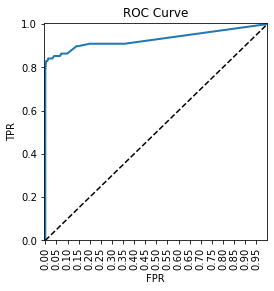

In [52]:
plot_roc_curve(fpr,tpr)

From the ROC Curve it's clear that it's hard to increase recall much without sacrificing precision

In [53]:
# Save the model
pickle.dump(rf_model, open("../models/rf_model.pkl", "wb"))

### Feature importances

In [54]:
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

In [55]:
def imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [56]:
base_imp = imp_df(X_train.columns, rf_model.feature_importances_)
base_imp

,feature,feature_importance
0,cbrt_V17,0.177236
1,cbrt_V16,0.167737
2,cbrt_V12,0.093912
3,cbrt_V14,0.066128
4,cbrt_V10,0.065877
5,V18,0.054351
6,V11,0.040420
7,cbrt_V7,0.030148
8,V4,0.024848
9,V9,0.023567


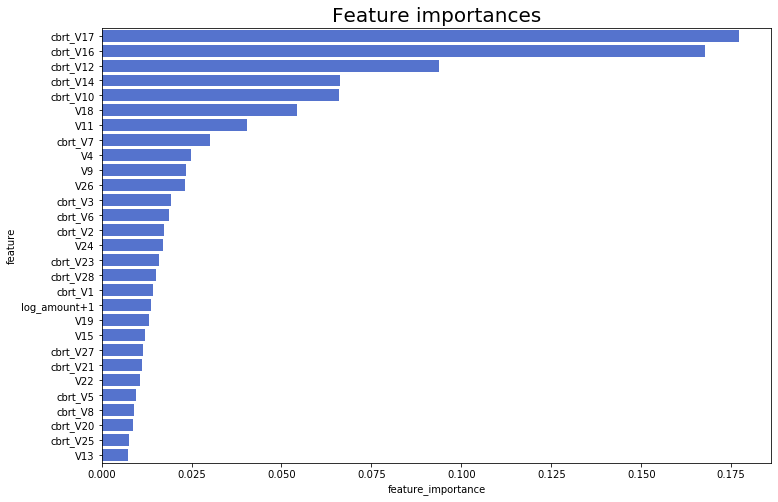

In [57]:
# most important features
plt.figure(figsize=(12,8))
imp_plot(base_imp, 'Feature importances')

No strikingly unimportant features, but could remove some of the lower ones in later models

## Try XGBoost model with early stopping

In [58]:
import xgboost as xgb

In [63]:
def train_XGB(lr, n_est, depth):
    xg = xgb.XGBClassifier(learning_rate=lr, n_estimators=n_est, max_depth=depth, n_jobs=-1, random_state=4)
    start = time.time()
    # eval parameters at https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
    eval_set=[(X_val, y_val)]
    xg_model = xg.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=50, eval_metric='auc', verbose=False)
    end = time.time()
    fit_time = (end - start)

    start = time.time()
    y_pred = xg_model.predict(X_val)
    end = time.time()
    pred_time = (end - start)

    precision, recall, fscore, train_support = score(y_val, y_pred, pos_label=1, average='binary')
    print('Learning Rate: {} / Est: {} / Depth: {} / Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        lr, n_est, depth, round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
        round(recall, 3), round((y_pred==y_val).sum()/len(y_pred), 3)))

In [64]:
# Use many short trees
for lr in [0.01, 0.1, 0.2, 0.5]:
    for n_est in [50, 100, 200, 500]:
        for depth in [10, 15, 20, 25]:
            train_XGB(lr, n_est, depth)

Est: 50 / Depth: 10 / Fit time: 23.673 / Predict time: 0.145 ---- Precision: 0.857 / Recall: 0.75 / Accuracy: 0.999
Est: 50 / Depth: 15 / Fit time: 32.453 / Predict time: 0.12 ---- Precision: 0.857 / Recall: 0.75 / Accuracy: 0.999
Est: 50 / Depth: 20 / Fit time: 26.813 / Predict time: 0.104 ---- Precision: 0.857 / Recall: 0.75 / Accuracy: 0.999
Est: 50 / Depth: 25 / Fit time: 24.02 / Predict time: 0.092 ---- Precision: 0.857 / Recall: 0.75 / Accuracy: 0.999
Est: 100 / Depth: 10 / Fit time: 52.798 / Predict time: 0.136 ---- Precision: 0.859 / Recall: 0.761 / Accuracy: 0.999
Est: 100 / Depth: 15 / Fit time: 47.897 / Predict time: 0.112 ---- Precision: 0.859 / Recall: 0.761 / Accuracy: 0.999
Est: 100 / Depth: 20 / Fit time: 50.814 / Predict time: 0.098 ---- Precision: 0.859 / Recall: 0.761 / Accuracy: 0.999
Est: 100 / Depth: 25 / Fit time: 53.155 / Predict time: 0.103 ---- Precision: 0.859 / Recall: 0.761 / Accuracy: 0.999
Est: 200 / Depth: 10 / Fit time: 57.507 / Predict time: 0.106 ----

Forgot to print the learning rate but ok. The best, cheap model is lr=0.1, n_est=100, depth=15

In [65]:
xg = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=15, n_jobs=-1, random_state=4)
eval_set=[(X_val, y_val)]
xg_model = xg.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=50, eval_metric='auc', verbose=False)
y_pred = xg_model.predict(X_val)

In [67]:
precision, recall, fscore, train_support = score(y_val, y_pred, pos_label=1, average='binary')
print('Learning Rate: {} / Est: {} / Depth: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        0.1, 100, 15, round(precision, 3), 
        round(recall, 3), round((y_pred==y_val).sum()/len(y_pred), 3)))

Learning Rate: 0.1 / Est: 100 / Depth: 15 ---- Precision: 0.945 / Recall: 0.784 / Accuracy: 1.0


In [68]:
# Just a difference in 1 from the random forest model
print(pd.DataFrame(confusion_matrix(y_val, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['real_neg', 'real_pos']))

          pred_neg  pred_pos
real_neg     56653         4
real_pos        19        69


In [69]:
# AUC is much better though
y_scores = xg_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_scores, pos_label=1)
# Area under curve
print(auc(fpr, tpr))

0.964934927402054


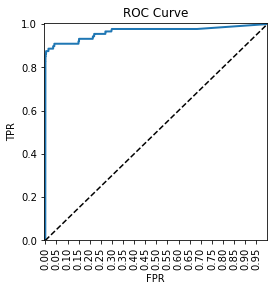

In [70]:
plot_roc_curve(fpr,tpr)

In [71]:
# Save the model
pickle.dump(xg_model, open("../models/xg_model.pkl", "wb"))

### Feature importances

In [73]:
base_imp = imp_df(X_train.columns, xg_model.feature_importances_)
base_imp

,feature,feature_importance
0,cbrt_V17,0.381196
1,cbrt_V14,0.053526
2,cbrt_V10,0.053044
3,cbrt_V27,0.033088
4,cbrt_V7,0.031679
5,V4,0.031582
6,cbrt_V12,0.025830
7,V9,0.023517
8,V26,0.023249
9,cbrt_V3,0.021680


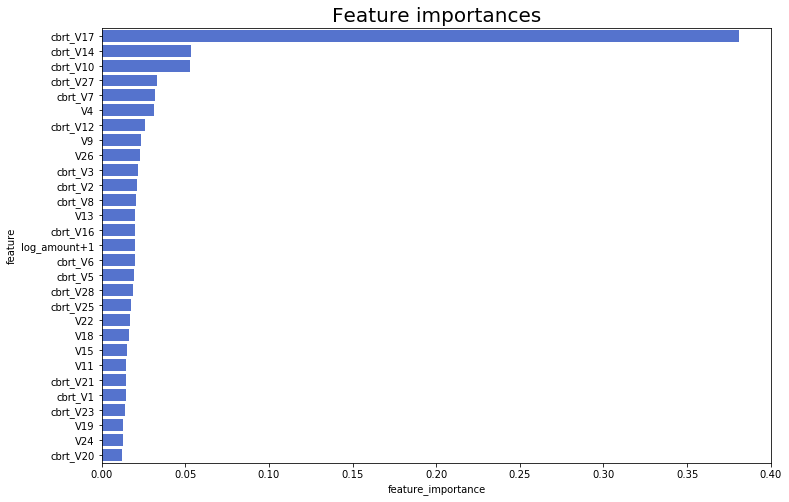

In [74]:
# most important features. cbrt_V17 is the most important feature again
plt.figure(figsize=(12,8))
imp_plot(base_imp, 'Feature importances')

## Next : Do some data balancing